In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import plotly.express as px
from tensorflow import keras
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import layers

In [2]:
# cel: zbuduj siec przewidujaca cene mieszkania
from tensorflow.keras.datasets import boston_housing

In [3]:
(xtrain, ytrain), (xtest, ytest) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [4]:
xtrain.shape, ytrain.shape, xtest.shape

((404, 13), (404,), (102, 13))

In [5]:
xtrain[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [8]:
# obejrzec statystyki atrybutów

df = pd.DataFrame(xtrain)
df.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


In [47]:
mean = xtrain.mean(axis=0)
std = xtrain.std(axis=0)

xtrainraw = np.copy(xtrain)
xtestraw = np.copy(xtest)

xtrain -=  mean
xtrain /= std
xtest -= mean
xtest /= std

xtrain.mean(axis=0), xtrain.std(axis=0), xtest.mean(axis=0), xtest.std(axis=0)

(array([-3.29769215e-18, -3.07784601e-17,  9.89307646e-18, -2.03357683e-16,
        -9.34346110e-18, -3.29769215e-18, -1.81373068e-17,  1.09923072e-18,
        -5.77096127e-18, -3.02288447e-18,  5.44119205e-17, -3.47631714e-17,
         5.49615359e-19]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([3.09233578e+00, 1.09019608e+01, 1.12649020e+01, 9.80392157e-02,
        5.44155882e-01, 6.35415686e+00, 6.68490196e+01, 4.01198235e+00,
        9.98039216e+00, 4.17500000e+02, 1.83745098e+01, 3.64163333e+02,
        1.23054902e+01]),
 array([5.34668449e+00, 2.14669193e+01, 7.04933605e+00, 2.97367664e-01,
        1.09473981e-01, 6.69031503e-01, 2.88923144e+01, 2.36827738e+00,
        8.72901449e+00, 1.76518774e+02, 2.01682561e+00, 7.87494364e+01,
        6.66249874e+00]))

In [27]:
def createModel(n1, n2):
    model = keras.Sequential([
        layers.Dense(n1, activation = 'relu'),
        layers.Dense(n2, activation = 'relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])
    return model

In [41]:
# zaimplmentujemy recznie n-krotna walidacje krzyzowa (k-fold cross-validation)
# iterowana kros walidacja - iteracyjnie permutujemy zbior - rozne zbiory
n = 5
epochs = 300

jointmetrics = []
jointmaehistories = []

nval = len(xtrain)//n

for i in range(n):
    xval = xtrain[i * nval : (i+1) * nval]
    yval = ytrain[i * nval : (i+1) * nval]
    xptrain = np.concatenate([xtrain[ : i * nval], xtrain[(i+1) * nval :]], axis=0)
    yptrain = np.concatenate([ytrain[ : i * nval], ytrain[(i+1) * nval :]], axis=0)
    model = createModel(64, 64)
    print(f" fold nr {i}")
    histdict = model.fit(xptrain, yptrain, epochs = epochs, batch_size = 32, verbose=0, validation_data = (xval, yval))
    maehistory = histdict.history["val_mae"]
    jointmaehistories.append(maehistory)
    vmse, vmae = model.evaluate(xval, yval)
    jointmetrics.append(vmae)

jointmetrics, np.mean(jointmetrics)

 fold nr 0
3/3 [==============================] - 0s 2ms/step - loss: 6.0239 - mae: 1.9426
 fold nr 1
3/3 [==============================] - 0s 1ms/step - loss: 16.6373 - mae: 2.8003
 fold nr 2
3/3 [==============================] - 0s 2ms/step - loss: 9.0726 - mae: 2.2847
 fold nr 3
3/3 [==============================] - 0s 2ms/step - loss: 12.7046 - mae: 2.3580
 fold nr 4
3/3 [==============================] - 0s 1ms/step - loss: 12.4940 - mae: 2.4474


([1.942552924156189,
  2.8002519607543945,
  2.284681797027588,
  2.357982873916626,
  2.4473824501037598],
 2.3665704011917112)

Text(0, 0.5, 'validation mae')

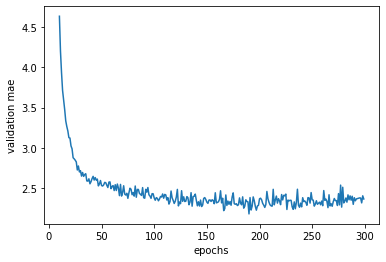

In [45]:
avemaehist = [ np.mean([h[i] for h in jointmaehistories]) for i in range(epochs) ]

plt.plot(range(10,len(avemaehist)), avemaehist[10:])
plt.xlabel("epochs")
plt.ylabel("validation mae")

In [48]:
model1 = createModel(64,64)
model1.fit(xtrain, ytrain, epochs = 250, batch_size=32, verbose=0)
testmse, testmae = model.evaluate(xtest, ytest)
testmse1, testmae1 = model1.evaluate(xtest, ytest)
testmae, testmae1

4/4 [==============================] - 0s 1000us/step - loss: 3339266.0000 - mae: 1793.7922


(2531.218017578125, 1793.792236328125)

In [50]:
model0 = createModel(64,64)
model0.fit(xtrainraw, ytrain, epochs = 250, batch_size = 32, verbose=0)
_, testmae0 = model0.evaluate(xtestraw, ytest)

4/4 [==============================] - 0s 2ms/step - loss: 5873735.0000 - mae: 2298.1042
